# Biclustering

**To Do**
* Create a meta metric (including multiple bic metrics) to evaluate bicluster model configs.
* Sensitive to high dim data? Should split into CT/PET/clinical features?

**Thesis**
* See radiomics study: *Radiomic feature clusters and Prognostic Signatures specific for Lung and Head & Neck cancer*, Parmar et al.


In [1]:
import numpy as np
import pandas as pd

import concensus_clustering

from copy import deepcopy

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# NB: For average Pearson use -1.0 * abs(rho). As rho improves 
# (indicating better results) a larger amount is subtracted to the 
# output indicating better overall biclusters.
def meta_score(scores, weights=None):
    """The weighted arithmetic mean of multiple scores.""" 
    
    if weights is None:
        weights = [0.5] * len(scores)
    
    outcome = 0
    for score, weight in zip(scores, weights):
        outcome = outcome + weight * -1.0 * abs(score)
        
    return outcome / len(scores)

In [3]:
def biclusters(model, X, param_config):
    # Create Bicluster instances tracking detected clusters.
    
    # Start fresh with each clustering.
    _model = deepcopy(model)
    
    # Set number of clusters to detect and fit model to data.
    _model.set_params(**param_config)
    _model.fit(X)

    rows, cols = _model.rows_, _model.columns_
    # Sanity check.
    assert np.shape(rows)[0] == np.shape(cols)[0]
    
    biclusters = concensus_clustering.Biclusters(
        rows=rows, cols=cols, data=X
    )
    return biclusters

In [4]:
def checker_coords(model, num_clusters):
    # Collect coordinates for biclusters with a checkerborad structure.
    
    tot_num_clusters = num_clusters[0] * num_clusters[1]
    coords = pd.DataFrame(
        np.zeros((tot_num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    
    num, prev_rows = 0, 0
    for row_num in range(num_clusters[0]):
        nrows = np.sum(model.rows_[row_num])

        prev_cols = 0
        for col_num in range(num_clusters[1]):
            ncols = np.sum(model.columns_[col_num])

            coords.iloc[num, 0] = prev_rows + 1
            coords.iloc[num, 1] = prev_rows + nrows
            coords.iloc[num, 2] = prev_cols
            coords.iloc[num, 3] = prev_cols + ncols

            num += 1

            prev_cols += ncols
        prev_rows += nrows - 1

    return coords

In [5]:
def bic_coords(model, num_clusters):
    # Collect coordinates for block diagonal biclusters.

    coords = pd.DataFrame(
        np.zeros((num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    prev_rows, prev_cols = 0, 0
    for num, row_bic in enumerate(model.rows_):
        num_rows = np.sum(row_bic)
        num_cols = np.sum(model.columns_[num])

        coords.iloc[num, 0] = prev_rows
        coords.iloc[num, 1] = prev_rows + num_rows
        coords.iloc[num, 2] = prev_cols
        coords.iloc[num, 3] = prev_cols + num_cols

        prev_rows += num_rows
        prev_cols += num_cols

    return coords

In [6]:
SEED = 0

In [7]:
X = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv', index_col=0)
X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,PET_original_gldm_SmallDependenceHighGrayLevelEmphasis.2,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis.2,PET_original_ngtdm_Busyness.2,PET_original_ngtdm_Coarseness.2,PET_original_ngtdm_Complexity.2,PET_original_ngtdm_Contrast.2,PET_original_ngtdm_Strength.2,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
patient,,,,,,,,,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,...,4430.229066,0.000370,0.025559,0.004672,27568.285932,0.296325,70.049351,21.616549,7.384,124.870726
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,...,4270.509796,0.000527,0.027591,0.007443,31578.673152,0.271854,156.965282,15.296275,3.406,41.554406
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,...,4096.292481,0.000460,0.022439,0.005178,24870.405544,0.230801,64.918103,14.473272,7.934,86.228420
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,...,1198.601513,0.000319,0.139365,0.001371,11651.530760,0.081103,15.731158,10.510859,26.926,205.413389
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,...,1122.798029,0.000459,0.048381,0.005789,7160.791790,0.118371,29.024761,7.213190,6.041,32.103770


In [8]:
X_std = StandardScaler().fit_transform(X.values)
X_std.shape

(198, 610)

# Spectral Biclustering

Ref: Kluger, Yuval, et. al., 2003. Spectral biclustering of microarray data: coclustering genes and conditions.

In [14]:
bic_grid = ParameterGrid(
    {
        'n_clusters': [
            (3, 3),
            (3, 5),
            (4, 7), 
            (7, 3),
            (9, 9),
            (5, 7),
            (9, 12),
            (11, 13), 
            (15, 3),
            (5, 17),
            (7, 10),
            (9, 20),
            (20, 9),
            (21, 21)
        ],
        'n_components': [6, 9, 10],
        'n_best': [1, 3, 6],
        
    }
)
# Id config with best score results and plot with grid.
bic_scores = {}
for num, bic_param_config in enumerate(bic_grid):
    bic_model = SpectralBiclustering(
        random_state=SEED, method='log', svd_method='arpack'
    )
    bic_clusters = biclusters(
        bic_model, X_std, bic_param_config
    )
    bic_scores[num] = bic_clusters.external_metrics

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:50: RuntimeWarning: divide by zero encountered in true_divide
  smsr_values = msr_values / (avg_rows ** 2 * avg_cols ** 2)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:50: RuntimeWarning: divide by zero encountered in true_divide
  smsr_values = msr_values / (avg_rows ** 2 * avg_cols ** 2)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols 

In [17]:
# Determine best biclustering config.
avg_bic_scores = []
for scores in bic_scores.values():
    _, non_inf_idx = np.where(scores.values != float('inf'))
    score = sum(scores.values.ravel()[non_inf_idx]) / len(non_inf_idx)
    avg_bic_scores.append(score)
    
best_config = bic_grid[np.argmin(avg_bic_scores)]
best_config

{'n_components': 6, 'n_clusters': (5, 17), 'n_best': 3}

In [18]:
bic_model = SpectralBiclustering(
    random_state=SEED, method='log', svd_method='arpack'
)
bic_model.set_params(**best_config)
bic_model.fit(X_std)
row_sorted = X_std[np.argsort(bic_model.row_labels_), :]
fit_data = row_sorted[:, np.argsort(bic_model.column_labels_)]

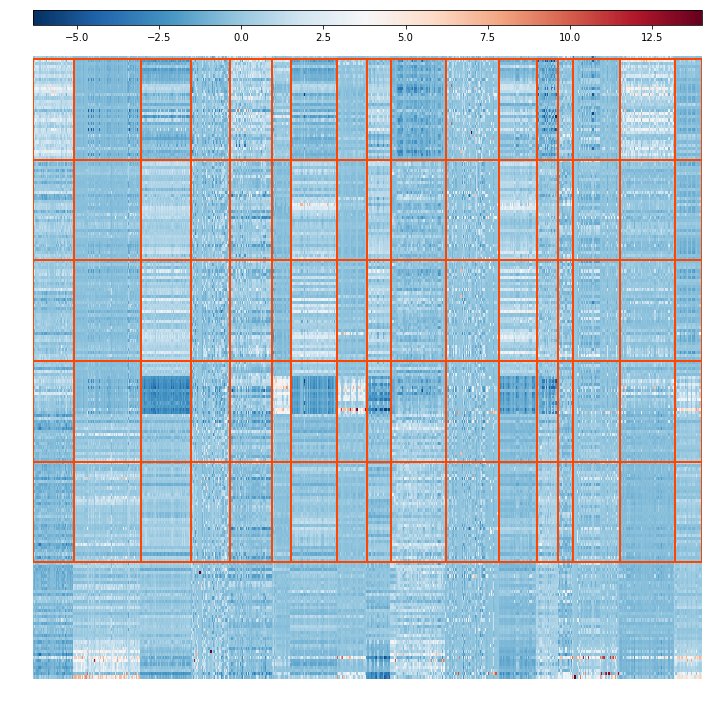

In [19]:
fig, (cbar_ax, map_ax) = plt.subplots(
    nrows=2, figsize=(10, 10),  
    gridspec_kw={'height_ratios':[0.025, 1]}
)
sns.heatmap(
    fit_data, ax=map_ax, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=np.min(fit_data), 
    vmax=np.max(fit_data),
    cbar=False
)
coords = checker_coords(bic_model, best_config['n_clusters'])
for num in coords.index:
    plt.plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='orangered' #darkred
)
fig.colorbar(
    map_ax.get_children()[0], 
    cax=cbar_ax, 
    orientation='horizontal'
)
plt.axis('off')
plt.tight_layout()

# Spectral Coclustering

In [13]:
co_grid = ParameterGrid(
    {
        'n_clusters': [3, 5, 7, 9, 11, 13, 17, 21]
    }
)
# Id config with best score results and plot with grid.
co_scores = {}
for num, co_param_config in enumerate(co_grid):
    co_model = SpectralCoclustering(
        random_state=SEED, svd_method='arpack'
    )
    co_clusters = biclusters(
        co_model, X_std, co_param_config
    )
    co_scores[num] = co_clusters.external_metrics

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
